# Beyin Tümörü MRI Sınıflandırma Modeli Geliştirme


Bu notebook, beyin tümörü MRI görüntülerini dört kategoriye sınıflandırmak için derin öğrenme modeli geliştirmeye odaklanmaktadır: Glioma, Meningioma, No tumor ve Pituitary.


## Gerekli Kütüphaneleri İçe Aktarma


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import random
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm



Tekrarlanabilirlik için rastgele sayı üretecini ayarlama


In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)



Grafik stilini ayarlama


In [3]:
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)



## Veri Hazırlama


Sabitleri tanımlama


In [4]:
DATA_DIR = Path('/Users/onurakyuz/Desktop/Brain Tumor MRI/data')
IMG_SIZE = (224, 224)  # Birçok CNN mimarisi için standart boyut
BATCH_SIZE = 32
EPOCHS = 20



Veri setinin var olup olmadığını kontrol etme


In [5]:
if not DATA_DIR.exists():
    print("Veri seti bulunamadı. Lütfen Kaggle'dan indirip data dizinine yerleştirin.")
else:
    print("Veri seti bulundu!")



Veri seti bulundu!


## Veri Artırma ve Yükleme


Eğitim seti için veri artırma


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Piksel değerlerini [0, 1] aralığına normalize etme
    rotation_range=20,  # Rastgele döndürme (±20 derece)
    width_shift_range=0.2,  # Yatay kaydırma
    height_shift_range=0.2,  # Dikey kaydırma
    shear_range=0.2,  # Kesme dönüşümü
    zoom_range=0.2,  # Yakınlaştırma
    horizontal_flip=True,  # Yatay çevirme
    fill_mode='nearest'  # Dönüşümlerden sonra boşlukları doldurma yöntemi
)



Test/doğrulama seti için sadece yeniden ölçeklendirme


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)



Veri artırma ile eğitim verilerini yükleme


In [8]:
train_generator = train_datagen.flow_from_directory(
    DATA_DIR / 'Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)



Found 5712 images belonging to 4 classes.


Test verilerini yükleme


In [9]:
test_generator = test_datagen.flow_from_directory(
    DATA_DIR / 'Testing',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 1311 images belonging to 4 classes.


Sınıf adlarını alma


In [10]:
class_names = list(train_generator.class_indices.keys())
print(f"Sınıf adları: {class_names}")



Sınıf adları: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Veri Artırma Örneklerini Görselleştirme


In [11]:
def visualize_data_augmentation():
    # Bir batch veri alma
    x_batch, y_batch = next(train_generator)
    
    # Rastgele 5 görüntü seçme
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    
    for i in range(3):
        for j in range(5):
            if i == 0 and j == 0:
                # Orijinal görüntüyü gösterme (veri artırma olmadan)
                img_path = random.choice(list((DATA_DIR / 'Training' / class_names[np.argmax(y_batch[0])]).glob('*.jpg')))
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)
                img = img / 255.0
                axes[i, j].imshow(img)
                axes[i, j].set_title('Orijinal Görüntü', fontsize=12)
            else:
                # Artırılmış görüntüleri gösterme
                idx = i * 5 + j if i > 0 or j > 0 else 1
                axes[i, j].imshow(x_batch[idx])
                axes[i, j].set_title(f'Artırılmış Görüntü {idx}', fontsize=12)
            
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Veri Artırma Örnekleri', fontsize=16, y=1.02)
    plt.show()



Veri artırma örneklerini görselleştirme


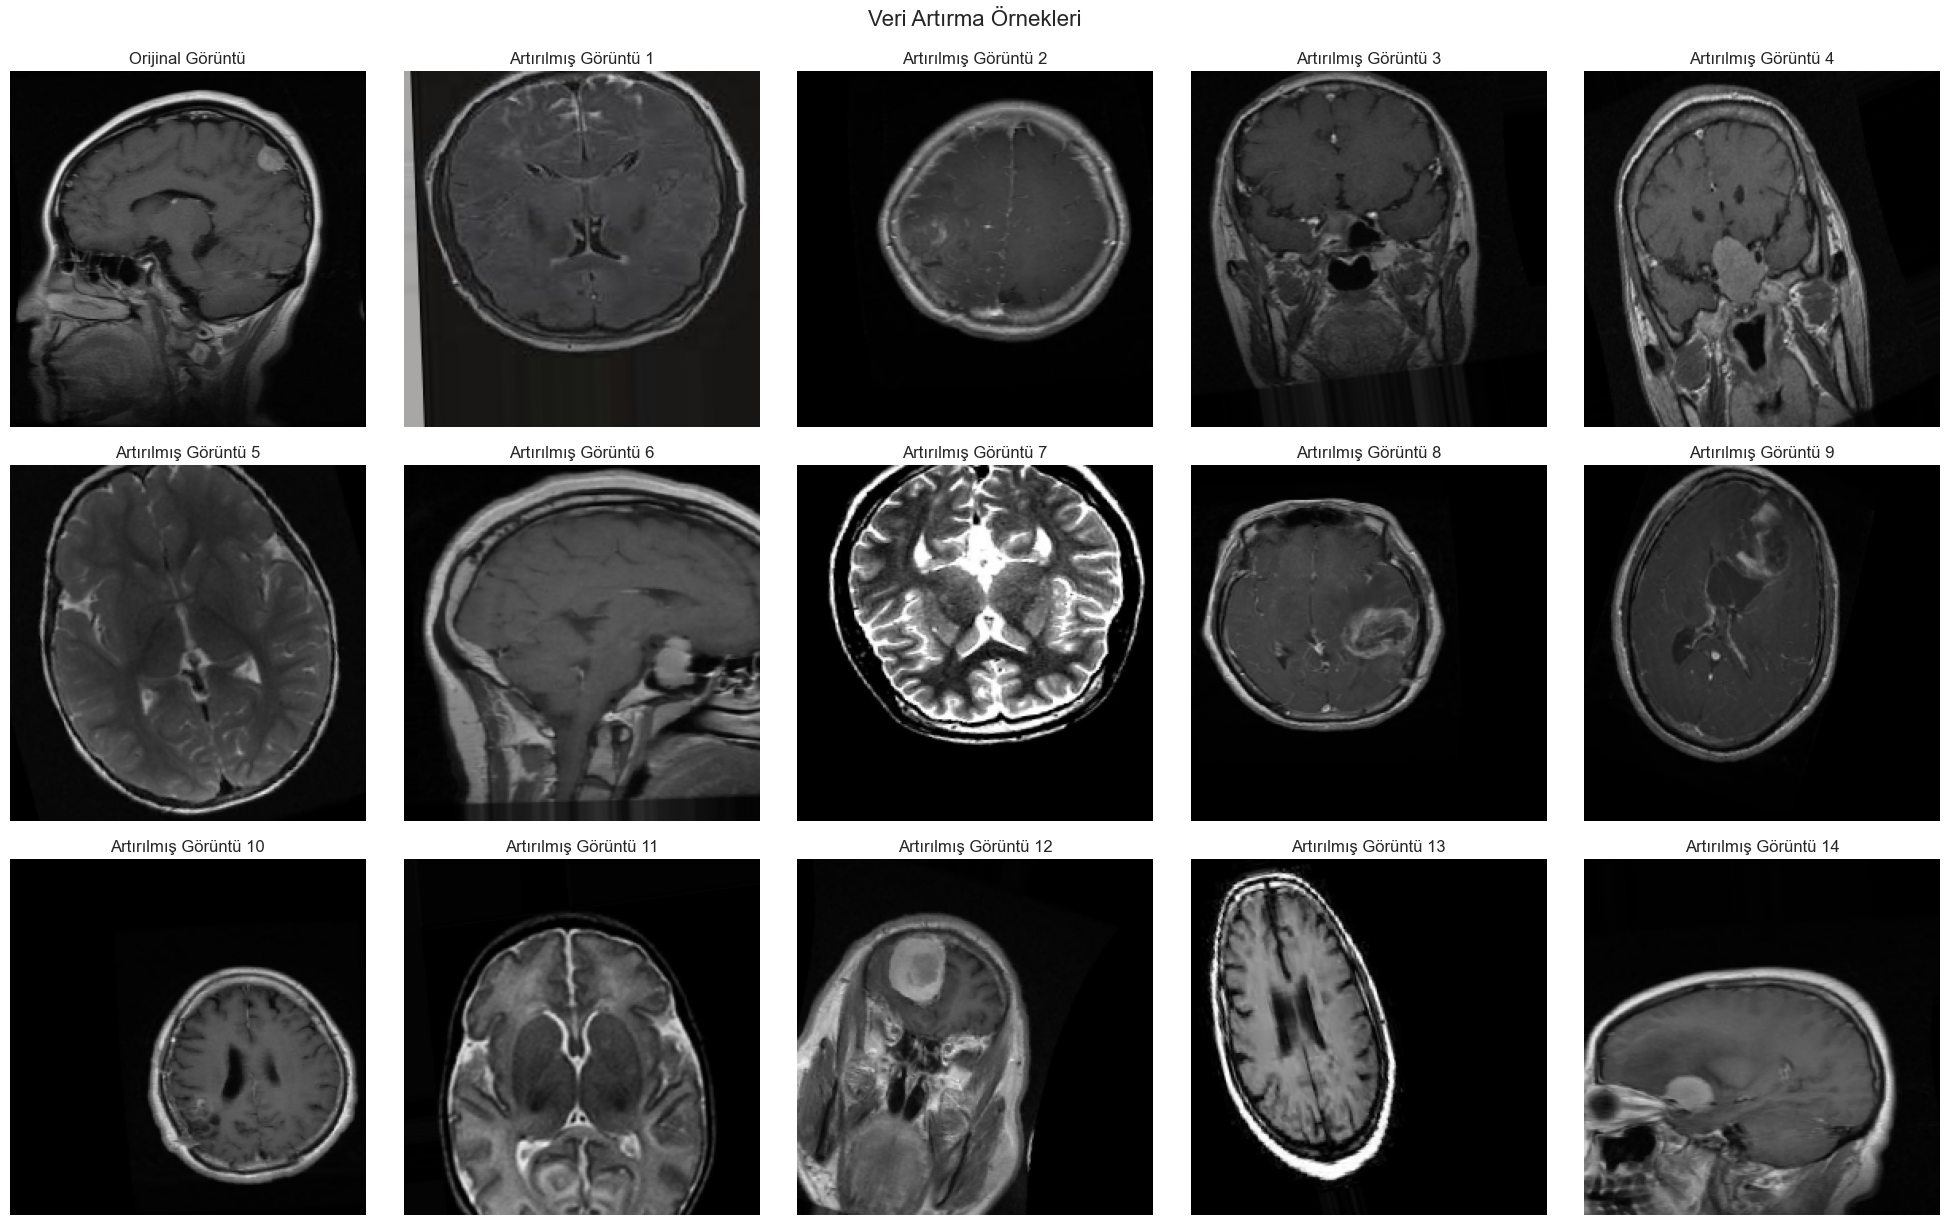

In [12]:
visualize_data_augmentation()



## Model Mimarisi


In [13]:
def create_model(input_shape=(224, 224, 3), num_classes=4):
    # Temel model olarak önceden eğitilmiş bir model kullanma
    base_model = applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,  # Üst katmanları (sınıflandırma katmanları) hariç tutma
        weights='imagenet'  # ImageNet ağırlıklarını kullanma
    )
    
    # Temel model katmanlarını dondurma (eğitim sırasında güncellenmeyecek)
    base_model.trainable = False
    
    # Modeli oluşturma
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Özellik haritalarını düzleştirme
        layers.Dense(128, activation='relu'),  # Tam bağlantılı katman
        layers.Dropout(0.5),  # Aşırı öğrenmeyi önlemek için dropout
        layers.Dense(num_classes, activation='softmax')  # Çıkış katmanı
    ])
    
    # Modeli derleme
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model



Modeli oluşturma


In [14]:
model = create_model(input_shape=IMG_SIZE + (3,), num_classes=len(class_names))
model.summary()



Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)

## Model Mimarisini Görselleştirme


In [ ]:
def visualize_model_architecture(model):
    # Model mimarisini görselleştirme
    tf.keras.utils.plot_model(
        model,
        to_file='model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB'
    )
    
    # Görüntüyü gösterme
    plt.figure(figsize=(12, 12))
    img = plt.imread('model_architecture.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Model Mimarisi', fontsize=16)
    plt.show()



Model mimarisini görselleştirme (TensorFlow 2.0+ ve pydot/graphviz gerektirir)


In [ ]:
try:
    visualize_model_architecture(model)
except Exception as e:
    print(f"Model mimarisi görselleştirilemedi: {e}")
    print("Bu özellik için 'pydot' ve 'graphviz' paketlerinin yüklenmesi gerekebilir.")



## Model Eğitimi


Geri çağırmaları tanımlama


In [ ]:
callbacks = [
    # Erken durdurma: Doğrulama kaybı 5 epoch boyunca iyileşmezse eğitimi durdurma
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True  # En iyi ağırlıkları geri yükleme
    ),
    # Öğrenme oranını azaltma: Doğrulama kaybı 3 epoch boyunca iyileşmezse öğrenme oranını azaltma
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.1,  # Öğrenme oranını 10 kat azaltma
        patience=3,
        min_lr=1e-6  # Minimum öğrenme oranı
    ),
    # Model kontrol noktası: En iyi modeli kaydetme
    tf.keras.callbacks.ModelCheckpoint(
        filepath='../models/brain_tumor_model.h5',
        save_best_only=True,  # Sadece en iyi modeli kaydetme
        monitor='val_accuracy'  # Doğrulama doğruluğuna göre izleme
    )
]



Modeli eğitme


In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks
)



## Eğitim Performansını Değerlendirme


Eğitim geçmişini çizme


In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Doğruluk grafiği
    axes[0].plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    axes[0].plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    axes[0].set_title('Model Doğruluğu', fontsize=16)
    axes[0].set_xlabel('Epoch', fontsize=14)
    axes[0].set_ylabel('Doğruluk', fontsize=14)
    axes[0].legend(fontsize=12)
    axes[0].grid(True)
    
    # Kayıp grafiği
    axes[1].plot(history.history['loss'], label='Eğitim Kaybı')
    axes[1].plot(history.history['val_loss'], label='Doğrulama Kaybı')
    axes[1].set_title('Model Kaybı', fontsize=16)
    axes[1].set_xlabel('Epoch', fontsize=14)
    axes[1].set_ylabel('Kayıp', fontsize=14)
    axes[1].legend(fontsize=12)
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()



Eğitim geçmişini çizme


In [ ]:
plot_training_history(history)



## Test Setinde Modeli Değerlendirme


Test setinde modeli değerlendirme


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test doğruluğu: {test_acc:.4f}")
print(f"Test kaybı: {test_loss:.4f}")



## Sınıflandırma Raporu ve Karışıklık Matrisi


Tahminleri alma


In [ ]:
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)



Gerçek etiketleri alma


In [ ]:
y_true = test_generator.classes



Sınıflandırma raporunu yazdırma


In [ ]:
print("Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))



Karışıklık matrisini çizme


In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Karışıklık Matrisi', fontsize=16)
plt.xlabel('Tahmin Edilen Etiket', fontsize=14)
plt.ylabel('Gerçek Etiket', fontsize=14)
plt.tight_layout()
plt.show()



## Model İnce Ayarı (Fine-tuning)


Temel modelin bazı katmanlarını ince ayar için çözme


In [ ]:
def fine_tune_model(model):
    # Temel modelin üst katmanlarını çözme
    base_model = model.layers[0]
    base_model.trainable = True
    
    # Son 30 katman hariç tüm katmanları dondurma
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    # Modeli daha düşük bir öğrenme oranıyla yeniden derleme
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model



Modeli ince ayarlama


In [ ]:
fine_tuned_model = fine_tune_model(model)



Eğitilebilir parametrelerin sayısını gösterme


In [ ]:
print(f"Toplam parametre: {fine_tuned_model.count_params():,}")
print(f"Eğitilebilir parametre: {sum([np.prod(v.get_shape()) for v in fine_tuned_model.trainable_weights]):,}")
print(f"Eğitilemez parametre: {sum([np.prod(v.get_shape()) for v in fine_tuned_model.non_trainable_weights]):,}")



Birkaç epoch daha eğitme


In [ ]:
fine_tune_history = fine_tuned_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks
)



İnce ayar eğitim geçmişini çizme


In [ ]:
plot_training_history(fine_tune_history)



## Modeli Kaydetme


models dizini yoksa oluşturma


In [ ]:
os.makedirs('../models', exist_ok=True)



Modeli kaydetme


In [ ]:
model.save('../models/brain_tumor_model.h5')
print("Model başarıyla kaydedildi!")



Sınıf adlarını kaydetme


In [ ]:
import json
with open('../models/class_names.json', 'w') as f:
    json.dump(class_names, f)
print("Sınıf adları başarıyla kaydedildi!")



## Örnek Görüntüler Üzerinde Modeli Test Etme


In [ ]:
def predict_image(model, img_path, class_names):
    # Görüntüyü okuma ve ön işleme
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, IMG_SIZE)
    img_normalized = img_resized / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)
    
    # Tahmin yapma
    prediction = model.predict(img_batch)[0]
    predicted_class = np.argmax(prediction)
    predicted_label = class_names[predicted_class]
    confidence = prediction[predicted_class]
    
    # Görüntüyü ve tahmini gösterme
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Tahmin: {predicted_label}\nGüven: {confidence:.2f}', fontsize=16)
    plt.axis('off')
    plt.show()
    
    # Tüm sınıf olasılıklarını gösterme
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=prediction)
    plt.title('Sınıf Olasılıkları', fontsize=16)
    plt.xlabel('Sınıf', fontsize=14)
    plt.ylabel('Olasılık', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return predicted_label, confidence



Test setinden birkaç rastgele görüntü üzerinde test etme


In [ ]:
test_dir = DATA_DIR / 'Testing'
class_dirs = [d for d in test_dir.iterdir() if d.is_dir()]

for _ in range(3):  # 3 rastgele görüntüyü test etme
    # Rastgele bir sınıf ve görüntü seçme
    class_dir = random.choice(class_dirs)
    img_path = random.choice(list(class_dir.glob('*.jpg')))
    
    print(f"Gerçek sınıf: {class_dir.name}")
    print(f"Görüntü yolu: {img_path}")
    
    # Tahmin etme
    predicted_label, confidence = predict_image(model, img_path, class_names)
    print(f"Tahmin edilen sınıf: {predicted_label}, güven: {confidence:.2f}")
    print("-" * 50)



## Grad-CAM ile Model Yorumlanabilirliği


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # İlk olarak, son evrişim katmanının çıktısını ve modelin tahmini üreten katmanını içeren bir model oluşturuyoruz
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Ardından, son evrişim katmanının çıktısına göre sınıf tahmini için gradyanları hesaplıyoruz
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Bu, son evrişim katmanının çıktısına göre sınıf tahmini için gradyanları verir
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Her özellik haritası için gradyanların önemini vektörleştirme
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Son evrişim katmanının çıktısını, özellik haritalarının önemine göre ağırlıklandırma
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Heatmap'i normalize etme
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Orijinal görüntüyü yükleme
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    
    # Heatmap'i görüntü boyutuna yeniden boyutlandırma
    heatmap = cv2.resize(heatmap, IMG_SIZE)
    
    # Heatmap'i RGB'ye dönüştürme
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Heatmap'i orijinal görüntüyle süperpoze etme
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    
    # Görüntüleri gösterme
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img)
    axes[0].set_title('Orijinal Görüntü', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(heatmap)
    axes[1].set_title('Grad-CAM Heatmap', fontsize=14)
    axes[1].axis('off')
    
    axes[2].imshow(superimposed_img)
    axes[2].set_title('Süperpoze Edilmiş Görüntü', fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()



Test setinden bir görüntü seçme


In [ ]:
test_dir = DATA_DIR / 'Testing'
class_dirs = [d for d in test_dir.iterdir() if d.is_dir()]
class_dir = random.choice(class_dirs)
img_path = random.choice(list(class_dir.glob('*.jpg')))



Görüntüyü ön işleme


In [ ]:
img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, IMG_SIZE)
img_normalized = img_resized / 255.0
img_batch = np.expand_dims(img_normalized, axis=0)



Tahmin yapma


In [ ]:
prediction = model.predict(img_batch)[0]
predicted_class = np.argmax(prediction)
predicted_label = class_names[predicted_class]
confidence = prediction[predicted_class]

print(f"Gerçek sınıf: {class_dir.name}")
print(f"Tahmin edilen sınıf: {predicted_label}, güven: {confidence:.2f}")



Grad-CAM heatmap'i oluşturma


In [ ]:
try:
    # MobileNetV2'nin son evrişim katmanının adını bulma
    last_conv_layer_name = None
    for layer in model.layers[0].layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
    
    if last_conv_layer_name:
        # Grad-CAM heatmap'i oluşturma
        heatmap = make_gradcam_heatmap(img_batch, model.layers[0], last_conv_layer_name, predicted_class)
        
        # Heatmap'i görüntüleme
        display_gradcam(img_path, heatmap)
    else:
        print("Son evrişim katmanı bulunamadı.")
except Exception as e:
    print(f"Grad-CAM görselleştirilemedi: {e}")



## Sonuç ve Sonraki Adımlar


Bu notebook'ta şunları gerçekleştirdik:


1. Beyin tümörü MRI veri setini model eğitimi için hazırladık


2. Eğitim örneklerinin çeşitliliğini artırmak için veri artırma uyguladık


3. MobileNetV2 ile transfer öğrenme kullanarak derin öğrenme modeli oluşturduk


4. Modeli eğittik ve performansını değerlendirdik


5. Modelin performansını artırmak için ince ayar yaptık


6. Örnek görüntüler üzerinde modeli test ettik


7. Grad-CAM ile model yorumlanabilirliğini gösterdik


Sonraki adımlar:


1. Web uygulaması oluşturarak modeli dağıtma


2. MRI görüntülerini yüklemek ve analiz etmek için bir kullanıcı arayüzü oluşturma


3. Farklı beyin tümörü türleri hakkında açıklamalar ve bilgiler ekleme


4. Model açıklanabilirliği tekniklerini (örn. Grad-CAM) uygulama
